# Platform Lifecycle Analysis

## Tujuan
Menganalisis performa platform sepanjang siklus hidup melalui:
- Umur platform sejak rilis awal
- Distribusi penjualan per fase umur
- Perubahan performa rata-rata game sepanjang lifecycle
- Catatan metodologi
- Year adalah tahun rilis game. 

Umur platform dihitung relatif terhadap tahun rilis pertama platform di dataset. Analisis membandingkan fase umur, bukan total historis mentah.

In [9]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

cwd = Path.cwd()
if (cwd / 'data').is_dir():
    data_path = cwd / 'data' / 'processed' / 'vgsales_cleaned.csv'
else:
    data_path = cwd.parent / 'data' / 'processed' / 'vgsales_cleaned.csv'

df = pd.read_csv(data_path)
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").round().astype("Int64")
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Total_Sales,Share_NA,Share_EU,Share_JP,decade_cohort
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,82.74,0.501450,0.350737,0.045564,2000.0
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,40.24,0.722664,0.088966,0.169235,1980.0
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,35.83,0.442367,0.359475,0.105777,2000.0
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,33.00,0.477273,0.333636,0.099394,2000.0
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,31.38,0.359146,0.283301,0.325685,1990.0


Dataset dipakai untuk menurunkan tahun rilis awal platform dan menghitung umur relatif setiap game.

## Menentukan tahun rilis platform
Tahun rilis platform didefinisikan sebagai tahun paling awal game muncul di dataset.

In [10]:
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

platform_launch = (
    df.dropna(subset=["Year"])
      .groupby("Platform")["Year"]
      .min()
      .rename("platform_launch_year")
)

df = df.join(platform_launch, on="Platform")
df[["Platform", "platform_launch_year"]].dropna().head()


,Platform,platform_launch_year
0,Wii,2006
1,NES,1983
2,Wii,2006
3,Wii,2006
4,GB,1988


Pendekatan ini tidak mengklaim tanggal rilis resmi platform, tetapi konsisten untuk perbandingan internal antar platform.

### Menghitung umur platform
Umur platform dihitung sebagai selisih tahun rilis game dengan tahun rilis awal platform.

In [11]:
df["platform_age"] = (df["Year"] - df["platform_launch_year"]).astype("Int64")
df["platform_age"].describe()


count     16327.0
mean     7.491027
std      8.033482
min           0.0
25%           2.0
50%           4.0
75%           8.0
max          35.0
Name: platform_age, dtype: Float64

Nilai negatif atau ekstrem menunjukkan data yang perlu diabaikan pada analisis lifecycle.

## Membuat fase lifecycle
Lifecycle dibagi menjadi tiga fase untuk stabilitas interpretasi.

In [13]:
age = df["platform_age"].astype(float)

conditions = [
    age <= 2,
    (age > 2) & (age <= 6),
    age > 6
]

choices = ["Early", "Mid", "Late"]

df["lifecycle_phase"] = np.select(conditions, choices, default=None).astype("object")
df["lifecycle_phase"].value_counts()


lifecycle_phase
Mid      7117
Late     4818
Early    4392
Name: count, dtype: int64

Fase disederhanakan agar perbandingan lintas platform tidak terlalu sensitif terhadap fluktuasi tahunan.

## Agregasi performa per fase
Mengukur jumlah game dan rata-rata penjualan per fase lifecycle.

In [14]:
lifecycle_perf = (
    df.dropna(subset=["lifecycle_phase"])
      .groupby("lifecycle_phase")
      .agg(
          title_count=("Name", "nunique"),
          avg_sales_per_title=("Total_Sales", "mean")
      )
      .reindex(["Early", "Mid", "Late"])
)

lifecycle_perf


,title_count,avg_sales_per_title
lifecycle_phase,,
Early,3641,0.679761
Mid,5501,0.548092
Late,4270,0.400494


Perubahan avg_sales_per_title menunjukkan apakah performa platform menguat atau melemah seiring umur.


## Visual performa lifecycle
Visual ini merangkum pola performa sepanjang siklus hidup platform.


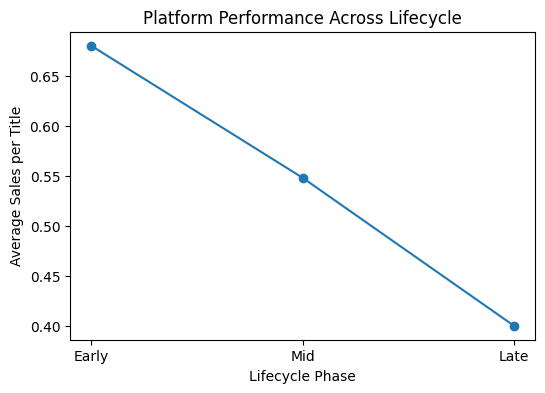

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(
    lifecycle_perf.index,
    lifecycle_perf["avg_sales_per_title"],
    marker="o"
)
plt.xlabel("Lifecycle Phase")
plt.ylabel("Average Sales per Title")
plt.title("Platform Performance Across Lifecycle")
plt.show()


Pola menurun mengindikasikan kelelahan platform. Pola stabil atau meningkat menunjukkan daya tahan ekosistem.

## Variasi antar platform
Analisis ini melihat apakah pola lifecycle konsisten atau berbeda antar platform utama.

In [17]:
top_platforms = (
    df.groupby("Platform")["Total_Sales"]
      .sum()
      .sort_values(ascending=False)
      .head(5)
      .index
)

platform_phase_perf = (
    df[df["Platform"].isin(top_platforms)]
      .dropna(subset=["lifecycle_phase"])
      .groupby(["Platform", "lifecycle_phase"])
      .agg(avg_sales=("Total_Sales", "mean"))
      .reset_index()
)

platform_phase_perf


,Platform,lifecycle_phase,avg_sales
0,DS,Early,0.020000
1,DS,Late,0.383640
2,PS2,Early,0.751335
3,PS2,Late,0.297399
4,PS2,Mid,0.638491
5,PS3,Early,0.838789
6,PS3,Late,0.554692
7,PS3,Mid,0.771584
8,Wii,Early,0.909727
9,Wii,Late,0.698636


Perbedaan pola antar platform menunjukkan bahwa umur panjang tidak selalu berarti performa stabil.

## Variasi antar platform berdasarkan total sales
Visual ini menunjukkan distribusi kontribusi penjualan antar platform utama. Tujuannya melihat apakah pasar terfragmentasi atau didominasi sedikit platform.

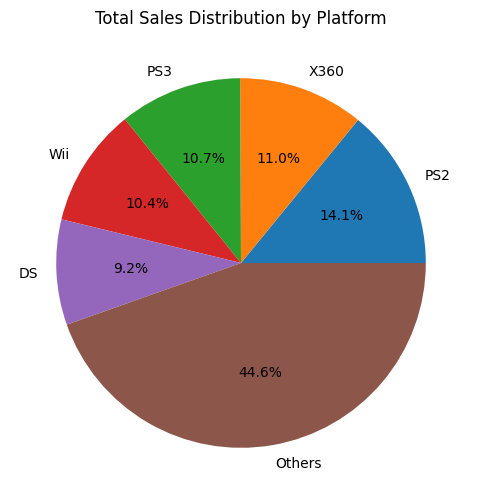

In [18]:
platform_total_sales = (
    df.groupby("Platform")["Total_Sales"]
      .sum()
      .sort_values(ascending=False)
)

top_platforms = platform_total_sales.head(5)
others = platform_total_sales.iloc[5:].sum()

pie_data = top_platforms.copy()
pie_data["Others"] = others

plt.figure(figsize=(6, 6))
plt.pie(pie_data.values, labels=pie_data.index, autopct="%1.1f%%")
plt.title("Total Sales Distribution by Platform")
plt.show()


Jika sebagian besar lingkaran dikuasai beberapa platform, pasar bersifat terpusat. Porsi “Others” yang besar menunjukkan fragmentasi dan kompetisi lintas ekosistem.

**insight**
- Platform memiliki pola performa berbeda sepanjang lifecycle.
- Fase awal sering menunjukkan performa tinggi per title.
- Penurunan performa mengindikasikan saturasi atau fragmentasi pasar.